In [1]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from diffcurve.fdct2d import get_curvelet_system
from diffcurve.fdct2d import fdct_wrapping, ifdct_wrapping
from diffcurve.utils import get_project_root

project_root = get_project_root()

lena_file = Path.joinpath(project_root, "data/Lena.jpg")

lena_img_square_even = cv2.imread(str(lena_file), 0).astype(float) / 255

In [2]:
def get_curvelet_decomposition(img, dct_kwargs):
    zeros = np.zeros_like(img)
    zero_coeffs = fdct_wrapping(zeros,
                                dct_kwargs['is_real'],
                                dct_kwargs['finest'],
                                dct_kwargs['nbscales'],
                                dct_kwargs['nbangles_coarse'])

    tmp = fdct_wrapping(zeros,
                            dct_kwargs['is_real'],
                            dct_kwargs['finest'],
                            dct_kwargs['nbscales'],
                            dct_kwargs['nbangles_coarse'])

    img_coeffs = fdct_wrapping(img,
                                   dct_kwargs['is_real'],
                                   dct_kwargs['finest'],
                                   dct_kwargs['nbscales'],
                                   dct_kwargs['nbangles_coarse'])

    all_scales_all_wedges_curvelet_coeffs = []
    for (scale_idx, curvelets_scale) in enumerate(zero_coeffs):
        print(f'scale {scale_idx}')
        for (wedge_idx, curvelet_wedge) in  enumerate(curvelets_scale):

            tmp[scale_idx][wedge_idx] = img_coeffs[scale_idx][wedge_idx]
            out = np.array(ifdct_wrapping(tmp))
            all_scales_all_wedges_curvelet_coeffs.append(out)
            tmp[scale_idx][wedge_idx] = zero_coeffs[scale_idx][wedge_idx]
    return all_scales_all_wedges_curvelet_coeffs

## DCT with implicit waveforms in MATLAB
In the MATLAB implementation, Curvelet waveforms are implicitly defined by the algorithms.

In [3]:
img = lena_img_square_even

dct_kwargs = {
    'is_real': 0.0, # complex-valued curvelets
    'finest': 2.0, # use wavelets at the finest level
    'nbscales': 6,
    'nbangles_coarse': 16}

In [4]:
matlab_decomp = get_curvelet_decomposition(img, dct_kwargs)
matlab_decomp = np.array(matlab_decomp)


scale 0
scale 1
scale 2
scale 3
scale 4
scale 5


MSE = 2.0685165495617353e-31


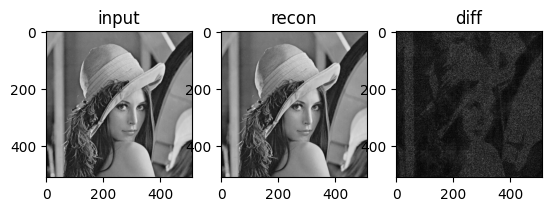

In [5]:
fig, axes = plt.subplots(1, 3)

axes[0].imshow( img , cmap='gray' )
axes[0].set_title('input')

axes[1].imshow( matlab_decomp.sum(0).real, cmap='gray' )
axes[1].set_title('recon')

axes[2].imshow( np.abs(matlab_decomp.sum(0).real - img), cmap='gray' )
axes[2].set_title('diff')

print(f'MSE = { np.mean( (matlab_decomp.sum(0).real - img) ** 2 ) }')

## DCT with explicit waveforms in numpy, JAX, and PyTorch

In [6]:
from diffcurve.fdct2d.numpy_frontend import perform_ifft2
import diffcurve
from diffcurve.fdct2d.jax_frontend import jax_fdct_2d, jax_ifdct_2d
from diffcurve.fdct2d.numpy_frontend import numpy_fdct_2d, numpy_ifdct_2d
from diffcurve.fdct2d.torch_frontend import torch_fdct_2d, torch_ifdct_2d
import torch


In [7]:
curvelet_system, curvelet_coeff_dim = get_curvelet_system(512, 512, dct_kwargs)

Text(0.5, 1.0, 'spatial')

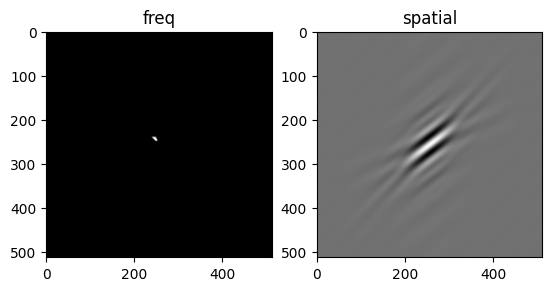

In [8]:
curvelet_idx = 1

fig, axes = plt.subplots(1, 2)


axes[0].imshow( (curvelet_system[curvelet_idx]).real, cmap='gray')
axes[0].set_title('freq')

axes[1].imshow( perform_ifft2(curvelet_system[curvelet_idx]).real, cmap='gray')
axes[1].set_title('spatial')

In [9]:

curvelet_support_size =  np.prod(curvelet_coeff_dim, 1)

jax_coeff = jax_fdct_2d(img, curvelet_system)

jax_decomp = jax_ifdct_2d(jax_coeff, curvelet_system, curvelet_support_size)

numpy_coeff = numpy_fdct_2d(img, curvelet_system)

numpy_decomp = numpy_ifdct_2d(numpy_coeff, curvelet_system, curvelet_support_size)



img_torch = torch.from_numpy(img)
curvelet_system_torch = torch.from_numpy(curvelet_system)
curvelet_support_size_torch = torch.from_numpy(curvelet_support_size)

torch_coeff = torch_fdct_2d(img_torch, curvelet_system_torch)

torch_decomp = torch_ifdct_2d(torch_coeff,
                              curvelet_system_torch,
                              curvelet_support_size_torch)


# Compare speed

In [10]:
%timeit numpy_ifdct_2d(numpy_fdct_2d(img, curvelet_system), curvelet_system, curvelet_support_size)


2.23 s ± 359 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit jax_ifdct_2d(jax_fdct_2d(img, curvelet_system), curvelet_system, curvelet_support_size).block_until_ready()


910 ms ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%timeit torch_ifdct_2d(torch_fdct_2d(img_torch, curvelet_system_torch), curvelet_system_torch, curvelet_support_size_torch)

2.2 s ± 27.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Compare result

In [13]:
print(np.allclose(matlab_decomp, numpy_decomp))
print(np.allclose(numpy_decomp, jax_decomp) )

torch_decomp_array = np.array(torch_decomp.detach().cpu())

print(np.allclose(jax_decomp, torch_decomp_array))

True
True


/var/folders/lh/5r0ljfq55b72g4z_69q8svb40000gq/T/ipykernel_65837/2253027399.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  torch_decomp_array = np.array(torch_decomp.detach().cpu())


True


In [14]:
from diffcurve.plot_utils import plot_images, remove_frame



<Figure size 640x480 with 0 Axes>

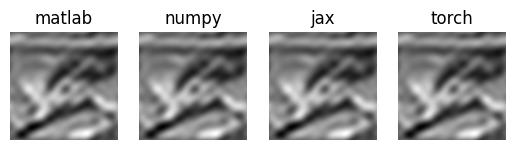

<Figure size 640x480 with 0 Axes>

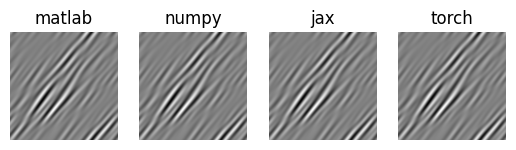

<Figure size 640x480 with 0 Axes>

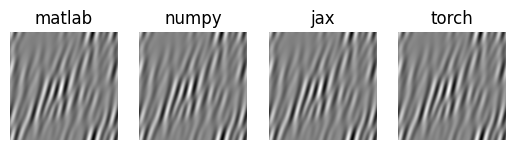

<Figure size 640x480 with 0 Axes>

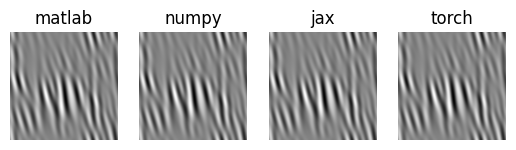

<Figure size 640x480 with 0 Axes>

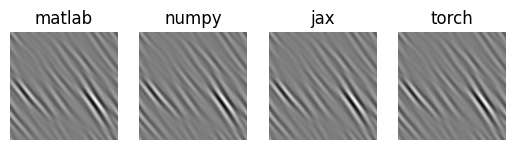

<Figure size 640x480 with 0 Axes>

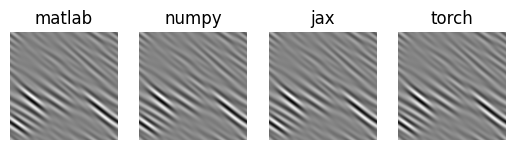

<Figure size 640x480 with 0 Axes>

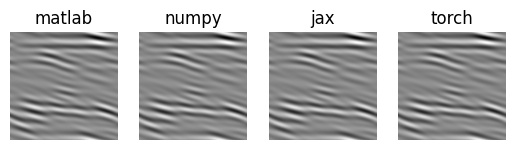

<Figure size 640x480 with 0 Axes>

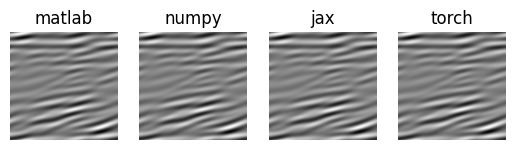

<Figure size 640x480 with 0 Axes>

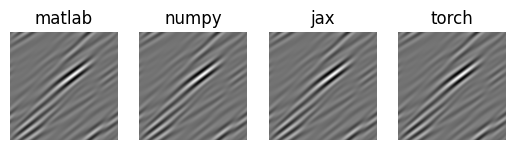

<Figure size 640x480 with 0 Axes>

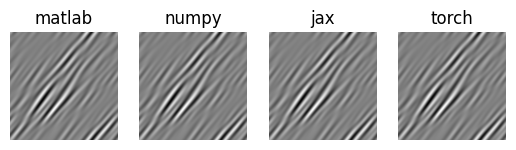

In [15]:
for curvelet_idx in range(10):

    plt.figure()

    im, axes = plot_images(
        [matlab_decomp[curvelet_idx].real.T,
         numpy_decomp[curvelet_idx].real.T,
         jax_decomp[curvelet_idx].real.T,
         torch_decomp_array[curvelet_idx].real.T],
        vrange = 'individual', cbar='none', cmap='gray')

    axes[0].set_title('matlab')
    axes[1].set_title('numpy')
    axes[2].set_title('jax')
    axes[3].set_title('torch')

    [remove_frame(ax) for ax in axes.flatten()];
    plt.plot()